# New York City Taxi Trip Duration (2016)

In [220]:
# Load libraries on Python 3 environment 

import pandas as pd
import numpy as np
import seaborn as sb 
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from PIL import Image
import requests
from io import StringIO
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

##  Data loading and overview

In [266]:
# Lookup given features on train and test data

LOCAL_PATH = '~/Downloads/nyc-taxi-trip-duration'
KAGGLE_PATH = '../input'
data_train = pd.read_csv(LOCAL_PATH + '/train.csv')
data_test = pd.read_csv(LOCAL_PATH + '/test.csv')
sample_sub = pd.read_csv(LOCAL_PATH + '/sample_submission.csv')

PLAN_URL = 'http://taxomita.com/wp-content/uploads/2017/12/map-of-areas-in-nyc-highway-map-of-new-york-city-metropolitan-area-highways.gif';
print(data_train.info())
print(data_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      6

In [267]:
print('We have {} training rows and {} test rows.'.format(data_train.shape[0], data_test.shape[0]))
print('We have {} training columns and {} test columns.'.format(data_train.shape[1], data_test.shape[1]))
data_train.head(3)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


We do not have null or nan values throughout the dataset.
As expected, "dropoff_datetime" and "trip_duration" columns are missing from test train.

## Date related feature extract

In [268]:
"""
Extract date, year, month, weekday, hour from columns
"""
def datetime_extract(df, columns, modeling=False):
    df_ = df.copy()
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for col in columns:
        try:
            prefix = col
            if "_" in col:
                prefix = col.split("_")[0]
            ts = f"{prefix}_ts"
            df_[ts] = pd.to_datetime(df_[col])
            df_[f"{prefix}_month"] = df_[ts].dt.month
            df_[f"{prefix}_weekday"] = df_[ts].dt.weekday
            df_[f"{prefix}_day"] = df_[ts].dt.day
            df_[f"{prefix}_hour"] = df_[ts].dt.hour
            df_[f"{prefix}_minute"] = df_[ts].dt.minute
            if not modeling: 
                df_[f"{prefix}_date"] = df_[ts].dt.date
                df_[f"{prefix}_dayname"] = df_[f"{prefix}_weekday"].apply(lambda x: day_names[x])
            else:
                df_.drop(columns=[ts, col], axis = 1)
        except:
            pass
    return df_

"""
Extract delta between two timestamps in minutes
"""
def timedelta_extract(df, colname, start, end):
    df_= df.copy()
    df_[f'{colname}'] = (df_[end] - df_[start]).astype('timedelta64[m]')
    return df_



In [269]:
df_train = datetime_extract(data_train, ['pickup_datetime', 'dropoff_datetime'])
df_train = timedelta_extract(df_train, 'delta_m', 'pickup_ts', 'dropoff_ts')

## Data analysis

In [270]:
df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_dayname,dropoff_ts,dropoff_month,dropoff_weekday,dropoff_day,dropoff_hour,dropoff_minute,dropoff_date,dropoff_dayname,delta_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14 17:32:30,3,0,14,17,32,2016-03-14,Monday,7.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12 00:54:38,6,6,12,0,54,2016-06-12,Sunday,11.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19 12:10:48,1,1,19,12,10,2016-01-19,Tuesday,35.0


### vendor_id feature

In [37]:
df_train.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

### pickup and dropoff date features

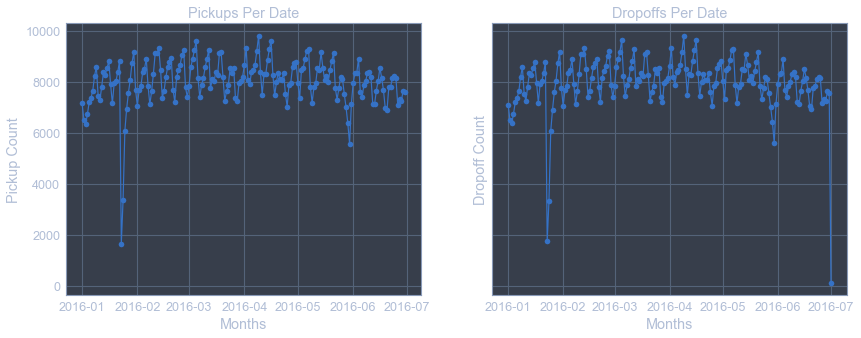

In [72]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(14, 5))
for i, col in enumerate(['pickup', 'dropoff']):
    ax[i].plot(df_train.groupby(f'{col}_date').count()['id'], 'o-')
    ax[i].set(xlabel='Months', ylabel=f'{col} count'.title(), title=f'{col}s per date'.title())
plt.show()

### passenger_count feature

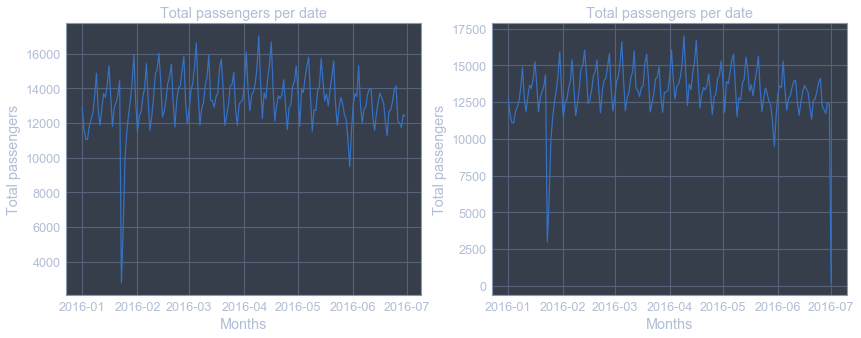

In [73]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
for i, col in enumerate(['pickup', 'dropoff']):
    ax[i].plot(df_train.groupby([f'{col}_date']).sum()['passenger_count'])
    ax[i].set(xlabel='Months', ylabel="Total passengers", title="Total passengers per date")


In [ ]:
    sb.distplot(df_train.passenger_count, kde=False, bins=df_train.passenger_count.max(), 
                vertical=True, axlabel="Passengers distribution");
    df_train.passenger_count.value_counts(sort=False)


### pickups and dropoffs geopoint features

#### NYC Roadmap

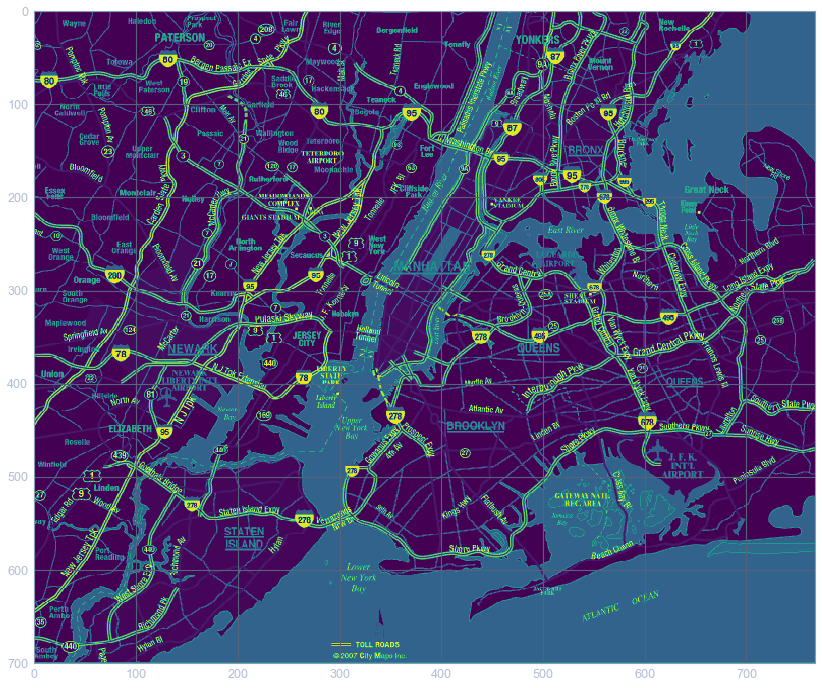

In [180]:
plan = requests.get(PLAN_URL)
img = Image.open(BytesIO(plan.content))
fig, ax = plt.subplots(figsize=(14, 12))
ax.imshow(np.asarray(img), aspect='auto')

#### Geo points vizualisation

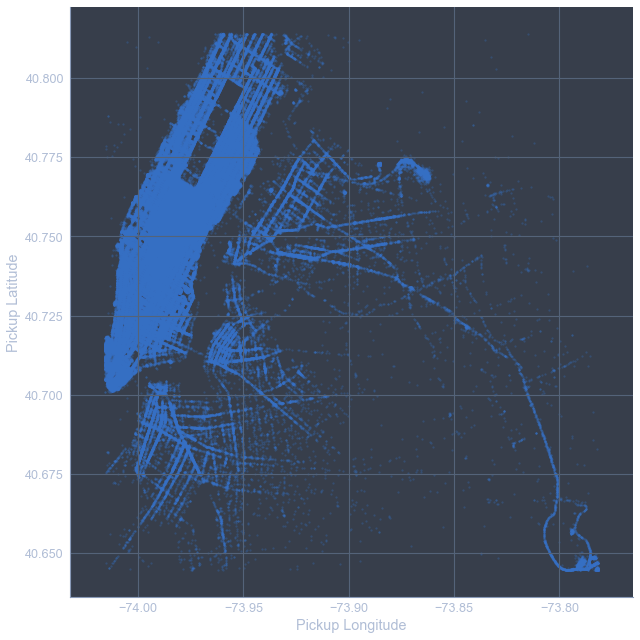

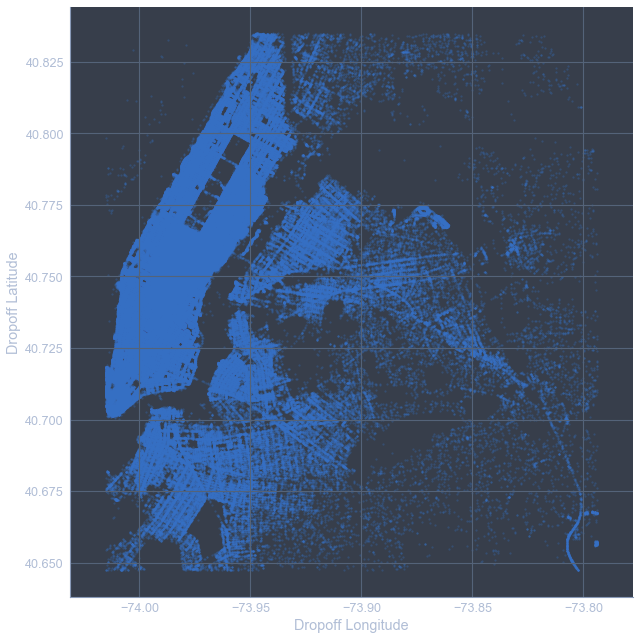

In [197]:
# Some pickups / dropoffs are outside NYC area, we are dropping outliers (geopoint > 95% and < 5%)
# https://www.kaggle.com/misfyre/in-depth-nyc-taxi-eda-also-w-animation

def rm_geo_outliers(df, columns):
    df_ = df.copy()
    for i, col in enumerate(columns):
        col_lat = f"{col}_latitude"
        col_lng = f"{col}_longitude"
        df_ = df_[(
             df_[col_lng]>df_[col_lng].quantile(0.005))
           &(df_[col_lng]<df_[col_lng].quantile(0.995))
           &(df_[col_lat]>df_[col_lat].quantile(0.005))                           
           &(df_[col_lat]<df_[col_lat].quantile(0.995))]
    return df_

def display_geo(df, columns):
    for i, col in enumerate(columns):
        col_lat = f"{col}_latitude"
        col_lng = f"{col}_longitude"
        sb.lmplot(x=col_lng, y=col_lat, fit_reg=False, height=9, scatter_kws={'alpha':0.3,'s':5},
                       data=df)

        plt.xlabel(f'{col} Longitude'.title());
        plt.ylabel(f'{col} Latitude'.title());
        plt.show()
    return

geo_columns = ['pickup', 'dropoff'];
df_train = rm_geo_outliers(df_train, geo_columns)
display_geo(df_train, geo_columns)


### store_and_fwd_flag feature

In [182]:
df_train.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

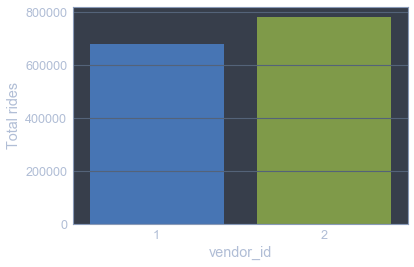

In [197]:
vendor_counts = df_train['vendor_id'].value_counts()

sb.barplot(vendor_counts.index, vendor_counts.values)
plt.xlabel('vendor_id')
plt.ylabel('Total rides')
plt.show()

### trip_duration feature

In [35]:
df_train.nlargest(5, 'trip_duration')[['id', 'trip_duration', 'delta_m']]

,id,trip_duration,delta_m
978383,id0053347,3526282,58771.0
924150,id1325766,2227612,37126.0
680594,id0369307,2049578,34159.0
355003,id1864733,1939736,32328.0
1234291,id1942836,86392,1439.0


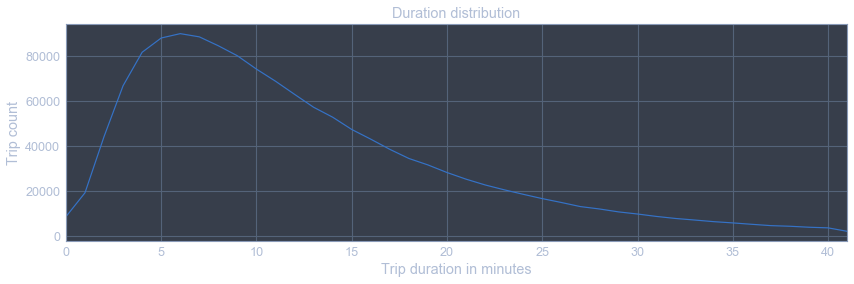

In [16]:
# We have some outliers, let's remove them (> .97 quantile)

fig, ax = plt.subplots(figsize=(14, 4))
tripduration = df_train[df_train.trip_duration < df_train.trip_duration.quantile(.97)]
tripduration.groupby('delta_m').count()['id'].plot()

plt.xlabel('Trip duration in minutes')
plt.ylabel('Trip count')
plt.title('Duration distribution')
plt.show()

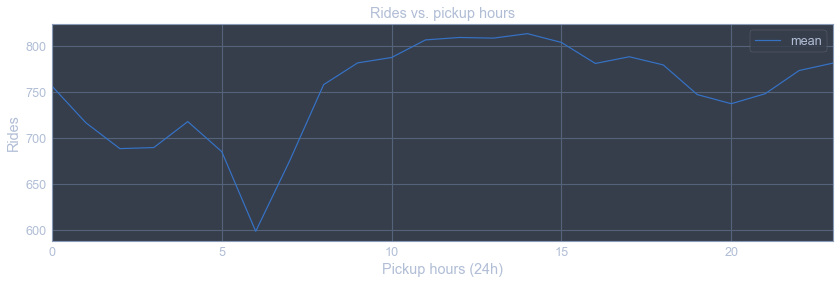

In [407]:
fig, ax = plt.subplots(figsize=(14, 4))
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.mean)['trip_duration'].plot(label='mean')

plt.legend(loc=0)
plt.xlabel('Pickup hours (24h)')
plt.ylabel('Rides')
plt.title('Rides vs. pickup hours')
plt.show()

## Modeling

### store_and_fwd_flag labeling 

In [300]:
df_train = datetime_extract(data_train, ['pickup_datetime', 'dropoff_datetime'], modeling=True)
df_test = datetime_extract(data_test, ['pickup_datetime'], modeling=True)

In [308]:
def label_encode(df, column):
    df_ = df.copy();
    try:
        le = LabelEncoder()
        le.fit(data_train[column])
        df_train[column] = le.transform(df_train[column])
        df_test[column] = le.transform(df_test[column])
    except:
        pass
    return df_

df_train = label_encode(df_train, 'store_and_fwd_flag')
df_test = label_encode(df_test, 'store_and_fwd_flag')

/usr/local/opt/pyenv/versions/3.6.0/lib/python3.6/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


### ids to predict extract

In [358]:
predict_ids = df_test['id']

### train test split

In [322]:
s_train, s_test = train_test_split(df_train, test_size = 0.2)
# Locally : s_train, s_test = train_test_split(df_train[0:100000], test_size = 0.2)

In [323]:
DROP_TRAIN = ['id', 'pickup_datetime', 'pickup_ts', 'dropoff_datetime', 'dropoff_ts']
DROP_PREDICT = DROP_TRAIN + ['trip_duration', 'dropoff_month', 'dropoff_weekday', 'dropoff_day',  'dropoff_hour', 'dropoff_minute'];

In [343]:
X_train = s_train.drop(DROP_TRAIN, axis = 1)
Y_train = s_train["trip_duration"]
Y_train = Y_train.reset_index().drop('index', axis = 1)

X_test = s_test.drop(DROP_TRAIN, axis = 1)
Y_test = s_test["trip_duration"]
Y_test = Y_test.reset_index().drop('index', axis = 1)

In [398]:
dtrain = xgb.DMatrix(X_train, label=np.log(Y_train+1))

In [399]:
dvalid = xgb.DMatrix(X_test, label=np.log(Y_test+1))

In [400]:
dtest = xgb.DMatrix(s_test.drop(DROP_TRAIN, axis = 1))

In [401]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost

#### Tuning parameters

In [369]:
 # https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial
"""
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]
for d in md:
    for l in lr:
        for w in mcw:
            t0 = datetime.now()
            
            xgb_pars = {'min_child_weight': w, 'eta': l, 'colsample_bytree': 0.9, 
                        'max_depth': d,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
            print('min_child_weight: {} | eta: {} | max-depth: {}.'.format(w, l, d))

            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
                  maximize=False, verbose_eval=1)
  """

min_child_weight: 20 | eta: 0.1 | max-depth: 6.
[0]	train-rmse:2851.59	valid-rmse:2786.84
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2572.06	valid-rmse:2516.11
[2]	train-rmse:2319.56	valid-rmse:2270.64
[3]	train-rmse:2093.34	valid-rmse:2046.24
[4]	train-rmse:1887.85	valid-rmse:1845.91
[5]	train-rmse:1867.43	valid-rmse:1825.96
[6]	train-rmse:1684.57	valid-rmse:1648.18
[7]	train-rmse:1520.17	valid-rmse:1485.4
[8]	train-rmse:1370.93	valid-rmse:1342.03
[9]	train-rmse:1236.8	valid-rmse:1213.65
[10]	train-rmse:1116.77	valid-rmse:1094.74
[11]	train-rmse:1007.96	valid-rmse:987.286
[12]	train-rmse:909.405	valid-rmse:892.986
[13]	train-rmse:901.416	valid-rmse:885.08
[14]	train-rmse:813.457	valid-rmse:801.177
[15]	train-rmse:734.591	valid-rmse:723.729
[16]	train-rmse:663.166	valid-rmse:653.164
[17]	train-rmse:598.651	valid-rmse:591.729
[18]	train-rmse:539.909	valid-rmse:533.787
[19

[25]	train-rmse:37.724	valid-rmse:96.5643
[26]	train-rmse:36.9919	valid-rmse:96.9747
[27]	train-rmse:36.4259	valid-rmse:96.8253
[28]	train-rmse:35.8384	valid-rmse:96.1029
[29]	train-rmse:35.3052	valid-rmse:96.2118
[30]	train-rmse:34.9654	valid-rmse:95.7744
[31]	train-rmse:34.5252	valid-rmse:95.7418
[32]	train-rmse:34.1651	valid-rmse:95.8921
[33]	train-rmse:33.8931	valid-rmse:95.1929
[34]	train-rmse:33.6321	valid-rmse:94.2954
[35]	train-rmse:33.2675	valid-rmse:94.2686
[36]	train-rmse:33.1335	valid-rmse:94.4759
[37]	train-rmse:32.5978	valid-rmse:94.9568
[38]	train-rmse:32.2873	valid-rmse:93.9085
[39]	train-rmse:31.918	valid-rmse:93.909
[40]	train-rmse:31.6467	valid-rmse:93.4209
[41]	train-rmse:31.2842	valid-rmse:93.3028
[42]	train-rmse:31.0905	valid-rmse:93.2873
[43]	train-rmse:30.7683	valid-rmse:92.3532
[44]	train-rmse:30.4449	valid-rmse:92.1524
[45]	train-rmse:30.1498	valid-rmse:92.0451
[46]	train-rmse:30.0007	valid-rmse:92.3251
[47]	train-rmse:29.7682	valid-rmse:91.6481
[48]	train-rms

#### Training

In [402]:
nrounds = 300
params = {'min_child_weight': 20, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 6,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(params, dtrain, nrounds, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)


[0]	train-rmse:4.21299	valid-rmse:4.21453
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.94963	valid-rmse:2.95099
[2]	train-rmse:2.06512	valid-rmse:2.06611
[3]	train-rmse:1.44589	valid-rmse:1.44657
[4]	train-rmse:1.01235	valid-rmse:1.01286
[5]	train-rmse:0.71353	valid-rmse:0.713837
[6]	train-rmse:0.499801	valid-rmse:0.500078
[7]	train-rmse:0.350251	valid-rmse:0.350536
[8]	train-rmse:0.245643	valid-rmse:0.24594
[9]	train-rmse:0.172496	valid-rmse:0.172832
[10]	train-rmse:0.121414	valid-rmse:0.121789
[11]	train-rmse:0.085845	valid-rmse:0.086252
[12]	train-rmse:0.061185	valid-rmse:0.061684
[13]	train-rmse:0.04496	valid-rmse:0.045587
[14]	train-rmse:0.033268	valid-rmse:0.034045
[15]	train-rmse:0.025557	valid-rmse:0.026527
[16]	train-rmse:0.020355	valid-rmse:0.021515
[17]	train-rmse:0.017088	valid-rmse:0.018405
[18]	train-rmse:0.015111	valid-rmse:0.016582
[19]	train-rmse:0.013991

#### Features weight

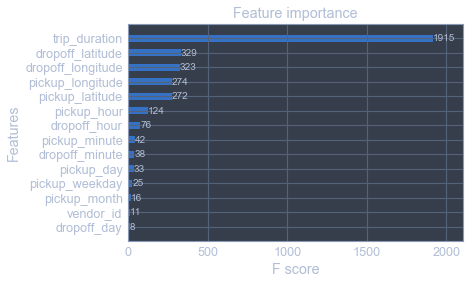

In [406]:
xgb.plot_importance(model, max_num_features=14, height=.5)

#### K means cross validation

In [408]:
n_folds = 5
early_stopping = 10
cv = xgb.cv(params, dtrain, 500, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)


[0]	train-rmse:4.21314+0.000758519	test-rmse:4.21313+0.00308179
[1]	train-rmse:2.94983+0.000537345	test-rmse:2.94982+0.00212306
[2]	train-rmse:2.06535+0.000374129	test-rmse:2.06535+0.00152464
[3]	train-rmse:1.44813+0.00419717	test-rmse:1.44798+0.00322253
[4]	train-rmse:1.01533+0.00339267	test-rmse:1.01534+0.00363639
[5]	train-rmse:0.712015+0.00243483	test-rmse:0.71204+0.00266097
[6]	train-rmse:0.498802+0.00184837	test-rmse:0.498816+0.00197584
[7]	train-rmse:0.350533+0.00275554	test-rmse:0.350591+0.00308049
[8]	train-rmse:0.245923+0.00218086	test-rmse:0.245964+0.00238246
[9]	train-rmse:0.172776+0.00181245	test-rmse:0.172819+0.00192221
[10]	train-rmse:0.121719+0.00165103	test-rmse:0.121784+0.00169279
[11]	train-rmse:0.086931+0.0024193	test-rmse:0.08705+0.00248318
[12]	train-rmse:0.0624768+0.00247045	test-rmse:0.0626766+0.00251872
[13]	train-rmse:0.0452222+0.0024205	test-rmse:0.0454808+0.00243976
[14]	train-rmse:0.033522+0.00258812	test-rmse:0.0338668+0.00256587
[15]	train-rmse:0.0258286+

[123]	train-rmse:0.0060906+0.00127624	test-rmse:0.00845+0.00149917
[124]	train-rmse:0.0060656+0.00125197	test-rmse:0.0084262+0.00148252
[125]	train-rmse:0.0060466+0.00124819	test-rmse:0.0084258+0.00148478
[126]	train-rmse:0.0060182+0.00126331	test-rmse:0.0084248+0.00148136
[127]	train-rmse:0.0060008+0.00126063	test-rmse:0.0084158+0.00147787
[128]	train-rmse:0.0059758+0.00125342	test-rmse:0.008394+0.00148829
[129]	train-rmse:0.0059456+0.00126387	test-rmse:0.0083782+0.0014883
[130]	train-rmse:0.0059198+0.00125449	test-rmse:0.0083626+0.00147316
[131]	train-rmse:0.0059082+0.00124901	test-rmse:0.008359+0.00147634
[132]	train-rmse:0.0058744+0.00122607	test-rmse:0.008344+0.00146442
[133]	train-rmse:0.0058586+0.0012187	test-rmse:0.008332+0.00145326
[134]	train-rmse:0.005815+0.00121193	test-rmse:0.0083012+0.00145221
[135]	train-rmse:0.0057932+0.00120681	test-rmse:0.0082976+0.00146922
[136]	train-rmse:0.0057686+0.0011878	test-rmse:0.008282+0.00145385
[137]	train-rmse:0.0057332+0.00117342	test-rm

[243]	train-rmse:0.0042374+0.0010277	test-rmse:0.0074436+0.00144836
[244]	train-rmse:0.0042296+0.00102454	test-rmse:0.007446+0.00144508
[245]	train-rmse:0.0042228+0.00102252	test-rmse:0.007438+0.00144062
[246]	train-rmse:0.0042082+0.00101262	test-rmse:0.0074298+0.00143606
[247]	train-rmse:0.0041932+0.00101806	test-rmse:0.0074284+0.00143919
[248]	train-rmse:0.004179+0.00101755	test-rmse:0.007411+0.00145731
[249]	train-rmse:0.0041652+0.00101637	test-rmse:0.0074046+0.00145481
[250]	train-rmse:0.004141+0.00102012	test-rmse:0.0073898+0.00146149
[251]	train-rmse:0.0041322+0.00101237	test-rmse:0.0073764+0.00145977
[252]	train-rmse:0.0041072+0.00100023	test-rmse:0.0073632+0.00144684
[253]	train-rmse:0.0040862+0.000991431	test-rmse:0.0073616+0.00144317
[254]	train-rmse:0.004081+0.000991767	test-rmse:0.0073566+0.00144262
[255]	train-rmse:0.0040682+0.000987476	test-rmse:0.007355+0.00144044
[256]	train-rmse:0.0040604+0.000982508	test-rmse:0.0073502+0.00143694
[257]	train-rmse:0.0040478+0.000981967

[362]	train-rmse:0.0032646+0.00091471	test-rmse:0.006986+0.00143148
[363]	train-rmse:0.0032578+0.000916383	test-rmse:0.006985+0.00142587
[364]	train-rmse:0.0032518+0.000919341	test-rmse:0.0069876+0.00142583
[365]	train-rmse:0.0032464+0.000917592	test-rmse:0.0069896+0.00142142
[366]	train-rmse:0.0032432+0.00091482	test-rmse:0.0069924+0.00141307
[367]	train-rmse:0.0032408+0.000913202	test-rmse:0.0070004+0.00141172
[368]	train-rmse:0.003233+0.000911458	test-rmse:0.0069962+0.00141101
[369]	train-rmse:0.0032286+0.00090998	test-rmse:0.0069932+0.00140733
[370]	train-rmse:0.0032214+0.00091098	test-rmse:0.006991+0.00140242
[371]	train-rmse:0.0032182+0.000908502	test-rmse:0.0069884+0.00140272
[372]	train-rmse:0.0032104+0.000901442	test-rmse:0.0069808+0.00140345
[373]	train-rmse:0.0032046+0.000904687	test-rmse:0.0069768+0.00141563
[374]	train-rmse:0.0031984+0.000900642	test-rmse:0.0069842+0.00141747
[375]	train-rmse:0.00319+0.000892281	test-rmse:0.0069812+0.00141247
[376]	train-rmse:0.0031856+0.0

[481]	train-rmse:0.0026996+0.000834809	test-rmse:0.0068262+0.0013828
[482]	train-rmse:0.0026932+0.000829954	test-rmse:0.0068254+0.00137974
[483]	train-rmse:0.0026876+0.000831506	test-rmse:0.0068196+0.00138802
[484]	train-rmse:0.0026814+0.00083176	test-rmse:0.0068172+0.00139293
[485]	train-rmse:0.0026764+0.000829824	test-rmse:0.0068178+0.00138866
[486]	train-rmse:0.0026728+0.000829071	test-rmse:0.006814+0.0013923
[487]	train-rmse:0.0026694+0.00082863	test-rmse:0.0068168+0.0013924
[488]	train-rmse:0.0026678+0.000828609	test-rmse:0.0068182+0.00139144
[489]	train-rmse:0.0026648+0.000828465	test-rmse:0.0068144+0.00139556
[490]	train-rmse:0.002661+0.000825627	test-rmse:0.0068152+0.00139256
[491]	train-rmse:0.0026572+0.000827398	test-rmse:0.0068142+0.00138982
[492]	train-rmse:0.0026554+0.000826696	test-rmse:0.0068148+0.00138941
[493]	train-rmse:0.0026518+0.000828347	test-rmse:0.006816+0.0013847
[494]	train-rmse:0.0026488+0.000827015	test-rmse:0.006814+0.00138925
[495]	train-rmse:0.0026424+0.0

#### Predict 

In [403]:
pred = np.exp(model.predict(dtest)) - 1

In [404]:
df_pred = pd.DataFrame({'id': predict_ids, 'trip_duration': pred})
# Locally : df_pred = pd.DataFrame({'id': predict_ids[:20000], 'trip_duration': pred}) 
df_pred = df_pred.set_index('id')
df_pred.to_csv('submission.csv', index = True)


,trip_duration
id,
id3004672,268.621277
id3505355,1182.057129
id1217141,286.648804
id2150126,838.896973
id1598245,557.086487
